## Improving Accuracy of Simulated Flows in Steeply Dipping Layers Using Vertically Staggered Grids with the XT3D Multi-Point Flux Approximation in MODFLOW 6

In [58]:
%run ./routines_KB.ipynb
%run ./figures_KB.ipynb
ws = './disu_model'

In [59]:
domain = True            # option to include "domain" (True) or not (False)
proposed = False         # option to re-proportion layer thickness in channel (0.1,0.8,0.1). nlay in channel must be 3.
spdis_recalc = False     # option to recalculate specific discharge within the notebook
dztol = 0.00001          # tolerance for determining overlap (dz > dztol) in a vertically staggered grid

In [60]:
# scenario parameters
# scenario names -- keys of parameters dictionary are scenario names
#                   built automatically from scenario options
# staggered -- vertically staggered grid, i.e., cross-connections (True)
#              or not, i.e., vertically offset (False)
# xt3d -- xt3d on (True) or off, i.e., standard formulation (False)

# scenario options
options = [
    {
        "optionname": "staggered",
        "optionstrings": {
            False: "-vo",
            True: "-vs",
        },
    },
    {
        "optionname": "xt3d",
        "optionstrings": {
            False: "-s",
            True: "-x",
        },
    },
]

# build parameters dictionary
parameters = build_parameters(options)

In [72]:
# Lx is the full width of the model. The grid spacing in the x direction is
# delr = Lx / ncol, and so the horizontal distance between the left and right
# boundary conditions is Lx - delr. The cells in the channel are square, i.e.,
# delz_chan = delr. The cross-sectional model has unit thickness "into the page,"
# i.e., nrow = 1 and delc = 1.

# The full thickness of the channel measured vertically is nlay_chan * delz_chan.
# Theta is the angle (deg) at which the channel slopes, and so the width of the
# "true" channel measured perpendicularly to the slope, i.e., the width available 
# for flow along the slope of the channel, is nlay_chan * delz_chan * cos(theta).
# The increase in elevation (vertical offset) as one moves a column to the right
# within the channel is delr * tan(theta).

# adjustable grid parameters
nlay_chan = 5                         # number of layers in channel
ncol = 11                             # number of columns in model
Lx = 11.0                             # full horizontal width of model
theta = 30.                           # angle of inclination of channel
k_dom = 1.e-6                         # domain conductivity

# set up dis grid and conductivities
mgs, nlay_dom_upper, inchan, delz_chan, zspan, zthick, zthick_dom_ll, nlay, delr, delc, thickness \
    = set_up_dis_grid(nlay_chan, ncol, Lx, theta, domain, proposed)
cond = set_up_cond(k_dom)
print(thickness.shape)
# arrays for storing results
models_all, head_all, spdismf6_all, q_all, qx_all, qy_all, qz_all, volflow_all = [], [], [], [], [], [], [], []

# Calculate volumetric flow Analytical = kai 
vol_flow_analytical = 1 * zthick * math.cos(math.radians(theta)) * 1
print('vol_flow_analytical ' , vol_flow_analytical)

# loop over scenarios
for i in range(len(parameters)):
    # convert to disu grid
    d2d = convert_to_disu(mgs, i, dztol)
    # run scenario and store results
    gwf, head, spdismf6, qx, qy, qz, qmagmid, qangmid, flowja, chdbud = simulation(i)
    
    # Volumetric flow Method 1 (vol_flow): Integrate cell volume x spdiscell / length channel (parallelogram, use midline)
    vol_flow = find_vol_flow(qx, qy, qz, thickness, inchan)
    flow_error = (vol_flow - vol_flow_analytical) / vol_flow_analytical
    # Volumetric flow Method 2 (vol_flow2): Constant head flow leaving model domain
    vol_flow2 = find_vol_flow2(chdbud)
    flow_error2 = (vol_flow2 - vol_flow_analytical) / vol_flow_analytical
    print(vol_flow, vol_flow2, flow_error, flow_error2)
    models_all.append(gwf), head_all.append(head), spdismf6_all.append(spdismf6), volflow_all.append(vol_flow)
    qx_all.append(qx), qy_all.append(qy), qz_all.append(qz)
    q_all.append((qmagmid, qangmid, flow_error))
    

(1, 1, 11)
(15, 1, 11)
vol_flow_analytical  4.330127018922194
5.085573526452102 5.773531722756517 0.17446289779230198 0.33334003772332743
4.565500343895959 5.162852900306242 0.054357141013464255 0.19230980471129946
4.058118986637835 4.094616287609341 -0.06281756426444597 -0.05438887364820843
3.805024414795662 3.8301505201051196 -0.12126725193785065 -0.11546462647220972


C:\Users\19904604\AppData\Local\Temp\ipykernel_8728\2625620749.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2,2,i+1,aspect="equal")
C:\Users\19904604\AppData\Local\Temp\ipykernel_8728\2625620749.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2,2,i+1,aspect="equal")
C:\Users\19904604\AppData\Local\Temp\ipykernel_8728\2625620749.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(2,2,i+1,aspect="equal")
C:\Users\19904604\AppData\Local\Temp\ipykernel_8728\2625620749.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecate

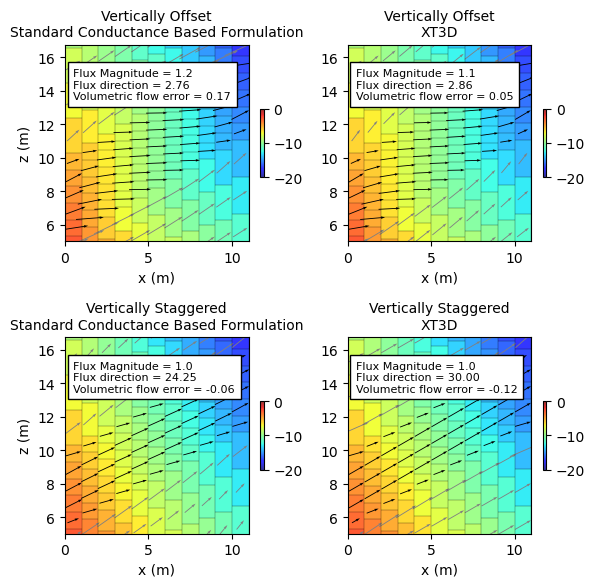

In [73]:
%run ./figures_KB.ipynb
extent = (0., Lx, zthick_dom_ll, zthick_dom_ll + zspan + delz_chan)
#extent = None
fig2(vmin = -20, vmax = 0, extent=extent, scale_chan=10., scale_dom=10.*k_dom, normalize=False)

In [74]:
%run ./figures_KB.ipynb
table1()

Vertically Offset
Standard Conductance Based Formulation
qmagmid =  1.156038773036343
qangmid =  2.7571180242526085
vol_flow =  5.085573526452102  Analytical = 4.330127018922194 

Vertically Offset
XT3D
qmagmid =  1.0613567758946445
qangmid =  2.855214694335104
vol_flow =  4.565500343895959  Analytical = 4.330127018922194 

Vertically Staggered
Standard Conductance Based Formulation
qmagmid =  1.0244628393256554
qangmid =  24.24679867385094
vol_flow =  4.058118986637835  Analytical = 4.330127018922194 

Vertically Staggered
XT3D
qmagmid =  0.9999995973836755
qangmid =  29.99998773142618
vol_flow =  3.805024414795662  Analytical = 4.330127018922194 



### Investigating adding model layers within hydrogeologic layers 

In [75]:
ncol = 11                             # number of columns in model
Lx = 11.0                             # full horizontal width of model
theta = 30.                           # angle of inclination of channel
k_dom = 1.e-6                         # domain conductivity

# grid resolution cases
resolution_scenarios = np.arange(1,11,1)
nr = len(resolution_scenarios)

# arrays for storing results
vo_results, vs_results, vflow_analytical = [], [], []

# loop over grid resolution cases
for n in range(nr):
    nlay_chan = resolution_scenarios[n]   # number of layers in channel
    vol_flow_analytical = 1 * zthick * math.cos(math.radians(theta))
    vflow_analytical.append(vol_flow_analytical)  
    # set up dis grid and conductivities
    mgs, nlay_dom_upper, inchan, delz_chan, zspan, zthick, zthick_dom_ll, nlay, delr, delc, thickness \
        = set_up_dis_grid(nlay_chan, ncol, Lx, theta, domain, proposed)
    cond = set_up_cond(k_dom)
    # run scenarios 1 and 3 (the two with XT3D) for this case and store results
        # convert to disu grid
    d2d = convert_to_disu(mgs, 1, dztol)
    gwf, head, spdismf6, qx, qy, qz, qmagmid, qangmid, flowja, chdbud = simulation(1)  # VO(XT3D)
    vol_flow = find_vol_flow(qx, qy, qz, delz_chan, inchan)   
    vol_flow2 = find_vol_flow2(chdbud)
    flow_error = (vol_flow2 - vol_flow_analytical) / vol_flow_analytical
    vo_results.append((nlay_chan, qmagmid, qangmid, vol_flow, flow_error))
    
    d2d = convert_to_disu(mgs, 3, dztol)
    gwf, head, spdismf6, qx, qy, qz, qmagmid, qangmid, flowja, chdbud = simulation(3)  # VS(XT3D)
    vol_flow = find_vol_flow(qx, qy, qz, thickness, inchan)   
    vol_flow2 = find_vol_flow2(chdbud)
    flow_error = (vol_flow2 - vol_flow_analytical) / vol_flow_analytical
    vs_results.append((nlay_chan, qmagmid, qangmid, vol_flow, flow_error))
    

(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)


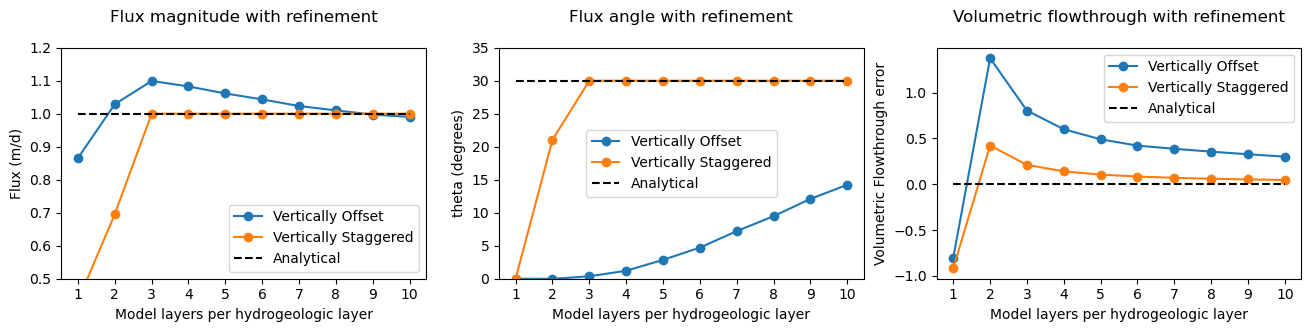

In [76]:
%run ./figures_KB.ipynb
fig3alt()

### Investigating K contrast between hydrogeologic layer and domain

In [10]:
nlay_chan = 2                         # number of layers in channel
ncol = 11                             # number of columns in model
Lx = 11.0                             # full horizontal width of model

# dip and K contrast cases
dip = np.arange(0, 80, 2.5)   # For nice contours use (0,80,1)
#log = np.arange(0, 3, 0.5)    # For nice contours use (0,4,0.2)
log = [0.25, 0.5, 1, 2]
Kcontrast = [10**i for i in log]

# arrays for storing results
qmag_results = np.zeros((4, len(Kcontrast), len(dip)))
qang_results = np.zeros((4, len(Kcontrast), len(dip)))
dip_array = np.zeros((4, len(Kcontrast), len(dip)))
Kcontrast_array = np.zeros((4, len(Kcontrast), len(dip)))

# loop over scenarios
for s in range(len(parameters)):
    # loop over dip cases
    for d in range(len(dip)):
        theta = dip[d]                        # angle of inclination of channel
        # set up dis grid
        mgs, nlay_dom_upper, inchan, delz_chan, zspan, zthick, zthick_dom_ll, nlay, delr, delc, thickness \
            = set_up_dis_grid(nlay_chan, ncol, Lx, theta, domain, proposed)
        d2d = convert_to_disu(mgs, s, dztol)
        # loop over K contrast cases
        for kc in range(len(Kcontrast)):
            k_dom = 1./Kcontrast[kc]              # domain conductivity
            # set up conductivities
            cond = set_up_cond(k_dom)
            # run case and store results
            #print('\nk_contrast = %i, dip = %i, scenario = %i' %(Kcontrast[kc], dip[d], s))
            gwf, head, spdismf6, qx, qy, qz, qmagmid, qangmid, flowja, chdbud = simulation(s)
            qmag_results[s][kc][d] = qmagmid
            qang_results[s][kc][d] = qangmid  
            Kcontrast_array[s][kc][d] = Kcontrast[kc]
            dip_array[s][kc][d] = dip[d]

(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)


(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
(1, 1, 11)
['                                   MODFLOW 6', '                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL', '                   VERSION 6.5.0 Release Candidate 03/26/2023', '                               ***DEVELOP MODE***', '', '   MODFLOW 6 compiled Mar 26 2023 03:09:29 with Intel(R) Fortran Intel(R) 64', '   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0', '                             Build 20220726_000000', '', 'This software is preliminary or provisional and is subject to ', 'revision. It is being provided to meet the need for timely best ', 'science. The software has not received final approval by the U.S. ', 'Geological Survey (USGS). No warranty, expressed or implied, is made ', 'by the USGS or the U.S. Government as to the functionality of the ', 'software and related material nor shall t

UnboundLocalError: local variable 'gwf' referenced before assignment

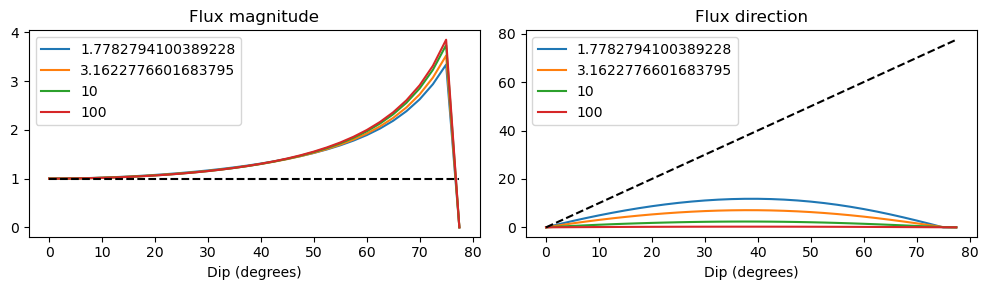

<Figure size 640x480 with 0 Axes>

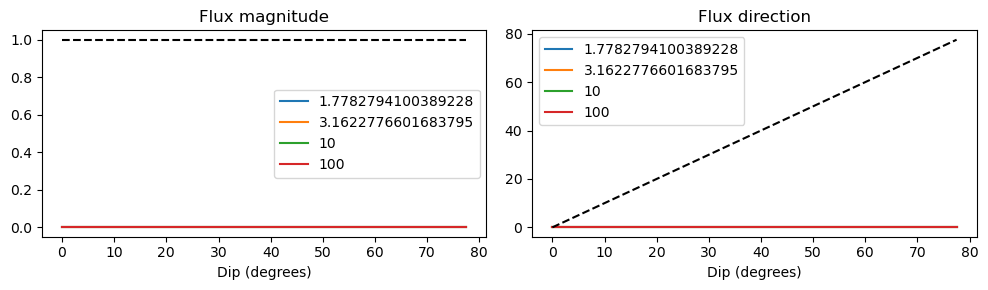

<Figure size 640x480 with 0 Axes>

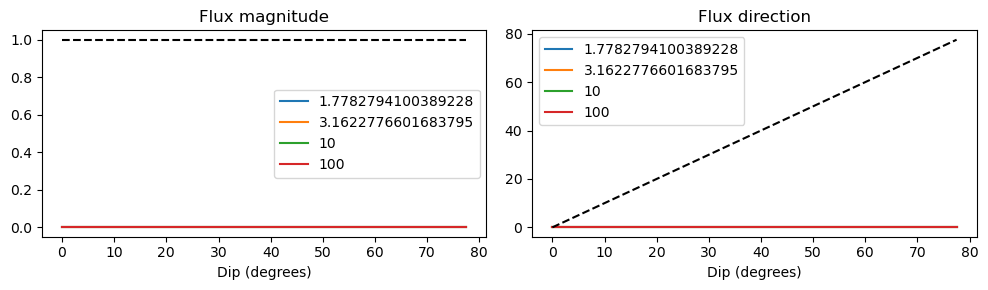

<Figure size 640x480 with 0 Axes>

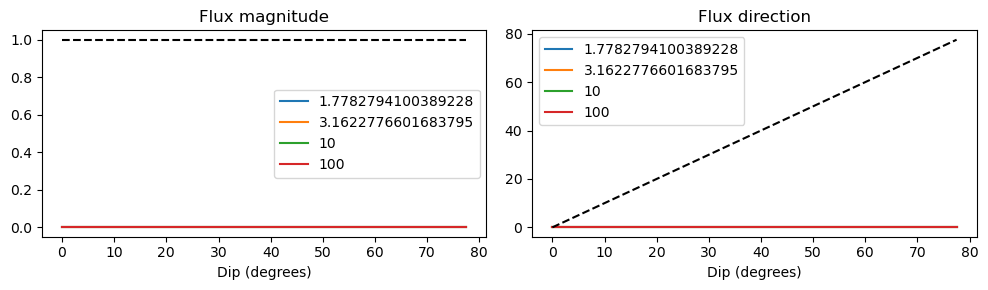

<Figure size 640x480 with 0 Axes>

In [12]:
fig4alt2()

In [ ]:
#fig4()